# Introduction To Data Science HW4 NBA Tidy Data Tutorial 

In [21]:
# This tidy data tutorial is doing the replication of the http://tomaugspurger.github.io/modern-5-tidy.html
# Since the html file data that basketball-reference.com has changed, for NBA_2016_games.html only shows the October games instead all 2016 seasons, result may not be the same as the reference

# To show graphs in jupyter notebook using %matplotlib inline 
%matplotlib inline 
# Import numby, pandas, seaborn, matplotlib.pyplot libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Check the os envrionment and set to modern_pandas_epub
if int(os.environ.get("MODERN_PANDAS_EPUB", 0)):
    import prep # noqa

# Set up Pandas for display max rows = 10
pd.options.display.max_rows = 10

# Set up Seaborn style = ticks and context = talk
sns.set(style='ticks', context='talk')

In [22]:
# Set up the directory for nba.csv to put in and name it as fp
fp = '/Users/ChienMingHuang/Desktop/Rutgers MIT Course/nba.csv'

# This if else is make sure that if in the directory without nba.csv file, then we will use pandas to read the nba html files for tables
# Let games = tables[0]
# And for games.to_csv to write the fp into csv file
# Else is that if exists fp, then pandas just needs to read fp csv file
if not os.path.exists(fp):
    tables = pd.read_html("http://www.basketball-reference.com/leagues/NBA_2016_games.html")
    games = tables[0]
    games.to_csv(fp)
else:
    games = pd.read_csv(fp)

# Show the head rows for games by .head()   
games.head()


,Unnamed: 0,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,,.1,Notes
0,0,"Tue, Oct 27, 2015",8:00 pm,Detroit Pistons,106,Atlanta Hawks,94,Box Score,NaN,NaN
1,1,"Tue, Oct 27, 2015",8:00 pm,Cleveland Cavaliers,95,Chicago Bulls,97,Box Score,NaN,NaN
2,2,"Tue, Oct 27, 2015",10:30 pm,New Orleans Pelicans,95,Golden State Warriors,111,Box Score,NaN,NaN
3,3,"Wed, Oct 28, 2015",7:30 pm,Philadelphia 76ers,95,Boston Celtics,112,Box Score,NaN,NaN
4,4,"Wed, Oct 28, 2015",7:30 pm,Chicago Bulls,115,Brooklyn Nets,100,Box Score,NaN,NaN


In [23]:
# Set up column_names and give every attributes their description
column_names = {'Date': 'date', 'Start (ET)': 'start',
                'Unamed: 2': 'box', 'Visitor/Neutral': 'away_team', 
                'PTS': 'away_points', 'Home/Neutral': 'home_team',
                'PTS.1': 'home_points', 'Unamed: 7': 'n_ot'}

# Use the rename for the columns to rename the games columns
# Dropna means drop the NA values with threshhold = 4, and used it to remove the "Month headers" that slipped into the table.
# For [['date', ...]] just show this five columns
# Assign the date use lambda function and give the date its format = '%a, %b %d, %Y'
# For set_index, using date, the original index as index and for append= TRUE means whether to append columns to existing index
# .Rename_axis for renaming the axis name as game_id and date
# .Sort_index for using the date for sorting
games = (games.rename(columns=column_names)
    .dropna(thresh=4)
    [['date', 'away_team', 'away_points', 'home_team', 'home_points']]
    .assign(date=lambda x: pd.to_datetime(x['date'], format='%a, %b %d, %Y'))
    .set_index('date', append=True)
    .rename_axis(["game_id", "date"])
    .sort_index())

# Show the head rows for games by .head() 
games.head()

,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94
1,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111
3,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112
4,2015-10-28,Chicago Bulls,115,Brooklyn Nets,100


In [149]:
# For creating the observation (team, game)
# Pandas melt function will melt away_team and home_team down into one column with multiple rows
# id_vars uses game_id and date and keep this in the tidy, and value varialbe use away_team and home_team
# value_name = team means will show what team is for the value
tidy = pd.melt(games.reset_index(),
               id_vars=['game_id', 'date'], value_vars=['away_team', 'home_team'],
               value_name='team')

# Show the head rows for tidy by .head() 
tidy.head()

,game_id,date,variable,team
0,0,2015-10-27,away_team,Detroit Pistons
1,1,2015-10-27,away_team,Cleveland Cavaliers
2,2,2015-10-27,away_team,New Orleans Pelicans
3,3,2015-10-28,away_team,Philadelphia 76ers
4,4,2015-10-28,away_team,Chicago Bulls


In [150]:
# Use .groupby to do the grouping of team
# Calculate the days of rest between games using diff().dt.days -1 to opearte the(date of today's game- date od previous game -1)
# For each team... get number of days between games
tidy.groupby('team')['date'].diff().dt.days - 1

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
     ... 
71    1.0
72    2.0
73    2.0
74    2.0
75    0.0
Name: date, Length: 76, dtype: float64

In [151]:
# Let tidy['rest'] equals the previous stuffs and do the date sort using .sort_values('date')
tidy['rest'] = tidy.sort_values('date').groupby('team').date.diff().dt.days - 1

# Show the head rows for tidy data by .head() and use .dropna() to drop NA values 
tidy.dropna().head()

,game_id,date,variable,team,rest
4,4,2015-10-28,away_team,Chicago Bulls,0.0
8,8,2015-10-28,away_team,Cleveland Cavaliers,0.0
14,14,2015-10-28,away_team,New Orleans Pelicans,0.0
17,17,2015-10-29,away_team,Memphis Grizzlies,0.0
18,18,2015-10-29,away_team,Dallas Mavericks,0.0


In [152]:
# Use .pivot_table to do a pivot table for by_game
# For pivot_table, data= tidy, and columns to aggreate is 'rest' using values, and using 'game_id' and 'date' as index
# Later using the columnes to tell the data type is 'variable'
# Use .rename function for renaming the column from 'away_team' to 'away_rest' and from 'home_team' to 'home_rest'
by_game = (pd.pivot_table(tidy, values='rest',
                          index=['game_id', 'date'],
                          columns='variable')
             .rename(columns={'away_team': 'away_rest',
                              'home_team': 'home_rest'}))
# Use .concat function to concatenate games and by_game, and axis= 1 means concatenate the columns
df = pd.concat([games, by_game], axis=1)

# Show the head rows for df data by .head() and use .dropna() to drop NA values 
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest
game_id,date,,,,,,
17,2015-10-29,Memphis Grizzlies,112,Indiana Pacers,103,0.0,0.0
18,2015-10-29,Dallas Mavericks,88,Los Angeles Clippers,104,0.0,0.0
19,2015-10-29,Atlanta Hawks,112,New York Knicks,101,1.0,0.0
20,2015-10-30,Charlotte Hornets,94,Atlanta Hawks,97,1.0,0.0
21,2015-10-30,Toronto Raptors,113,Boston Celtics,103,1.0,1.0


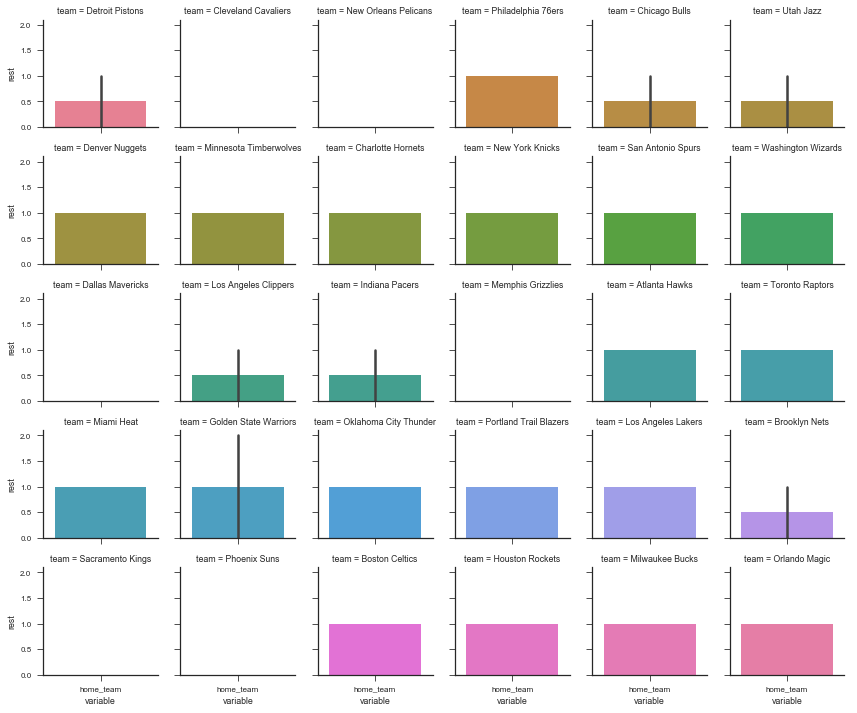

In [187]:
# In this part, we use seaborn to do some data visualization
# Use seaborn .set function to set the seaborn visualization style as ticks and context as paper
sns.set(style='ticks', context='paper')

# Use the .FacetGrid function to link panda dataframe to a matplotlib figure with below structure 
# Data = tidy, col= 'team' means for the plot column side is 'team', col_wrap= 6 means that wrap the column variable at 6 this width. so in the picture will show six some plots in one rows
# hue= 'team' means that different team will different color in the plot and size= 2 means will be 2 inches height of each facet
g = sns.FacetGrid(tidy, col='team', col_wrap=6, hue='team', size=2)

# Use .map function to apply seaborn bar plot using .barplot, and set the input as variable and rest to get the plots
g.map(sns.barplot, 'variable', 'rest');

In [155]:
# To define de['home_win'] using the definition that df['home_points'] is larger than df['away_points'] to get the result
df['home_win'] = df['home_points'] > df['away_points']

# To define df['rest_spread'] using the definition that df['home_rest'] minus df['away_rest'] to get the result
df['rest_spread'] = df['home_rest'] - df['away_rest']

# Show the head rows for df data by .head() and use .dropna() to drop NA values 
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread
game_id,date,,,,,,,,
17,2015-10-29,Memphis Grizzlies,112,Indiana Pacers,103,0.0,0.0,False,0.0
18,2015-10-29,Dallas Mavericks,88,Los Angeles Clippers,104,0.0,0.0,True,0.0
19,2015-10-29,Atlanta Hawks,112,New York Knicks,101,1.0,0.0,False,-1.0
20,2015-10-30,Charlotte Hornets,94,Atlanta Hawks,97,1.0,0.0,True,-1.0
21,2015-10-30,Toronto Raptors,113,Boston Celtics,103,1.0,1.0,False,0.0


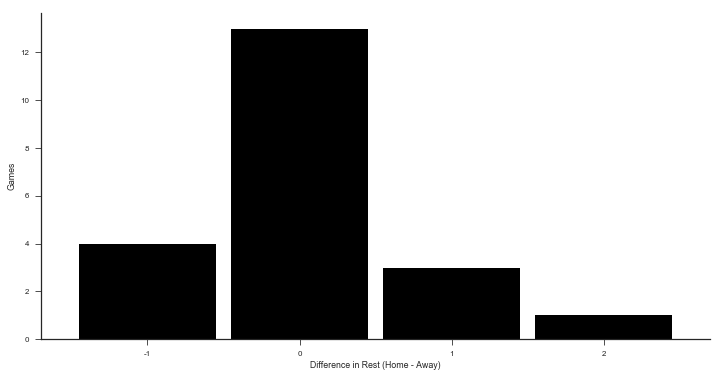

In [189]:
# Let delta equals the result that home_rest in the by_game minus the away_rest in the by_game and use .dropna() to drop NA values and .astype function for set the data type as interger
delta = (by_game.home_rest - by_game.away_rest).dropna().astype(int)

# Let ax equals the delta value_count bar plot
# Use .reindex function with .arrange function for the interval between delta.min() and delta.max() + 1, and use fill_values= 0 to fill the NA values as 0
# Use .sort_index function to do the sorting for previous interval
# Use .plot function to do the bar plot by kind= 'bar', and give color as black for color='k' and give the width= 0.9
# Also rot= 0 means to rotate the xticks and figsize= (12, 6) means give the width= 12 inches and height= 6 inches for the tuple
ax = (delta.value_counts()
    .reindex(np.arange(delta.min(), delta.max() + 1), fill_value=0)
    .sort_index()
    .plot(kind='bar', color='k', width=.9, rot=0, figsize=(12, 6))
)

# Use .despine function to remove the top and right spines from plot
sns.despine()

# Use .set function to set the xlabel='Difference in Rest (Home - Away)' and ylabel='Games'
ax.set(xlabel='Difference in Rest (Home - Away)', ylabel='Games');

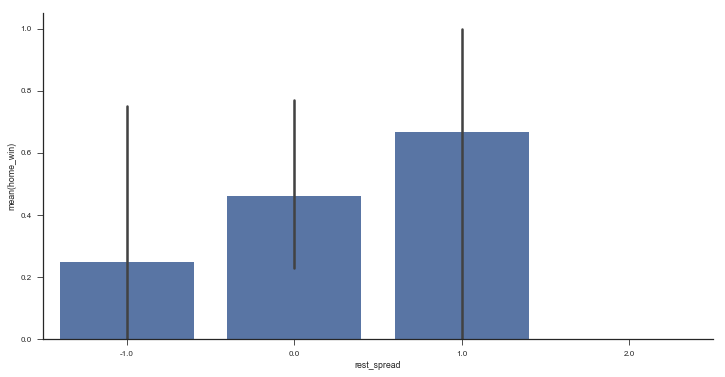

In [174]:
# Use .subplots function to a subplot for ax as give the figsize width= 12 inches and height= 6 inches
fig, ax = plt.subplots(figsize=(12, 6))

# Do a barplot for xlabel= rest_spread', ylabel='home_win', and put the data of the query result that fit in '-3 <= rest_spread <= 3' this range
# Also set up the color as '#4c72b0' this color and matplotlib axes ax= ax
sns.barplot(x='rest_spread', y='home_win', data=df.query('-3 <= rest_spread <= 3'),
            color='#4c72b0', ax=ax)

# Use .despine function to remove the top and right spines from plot
sns.despine()

In [158]:
# Set rest equals the tidy data with grouping by date and variable and use .rest.mean to get rest mean and .dropna() to drop NA values
rest = (tidy.groupby(['date', 'variable'])
            .rest.mean()
            .dropna())

# Show the head rows for rest data by .head() 
rest.head()

date        variable 
2015-10-28  away_team    0.000000
            home_team    0.000000
2015-10-29  away_team    0.333333
            home_team    0.000000
2015-10-30  away_team    1.083333
Name: rest, dtype: float64

In [159]:
# Show the head rows for rest data by .head() and use .unstack() to convert from long to wide format
rest.unstack().head()

variable,away_team,home_team
date,,
2015-10-28,0.000000,0.000000
2015-10-29,0.333333,0.000000
2015-10-30,1.083333,0.916667
2015-10-31,0.166667,0.833333


In [160]:
# Show the level MultiIndex move up to the columns by. unstack() and convert from wide to long format by .stack()
rest.unstack().stack()

date        variable 
2015-10-28  away_team    0.000000
            home_team    0.000000
2015-10-29  away_team    0.333333
            home_team    0.000000
2015-10-30  away_team    1.083333
            home_team    0.916667
2015-10-31  away_team    0.166667
            home_team    0.833333
dtype: float64

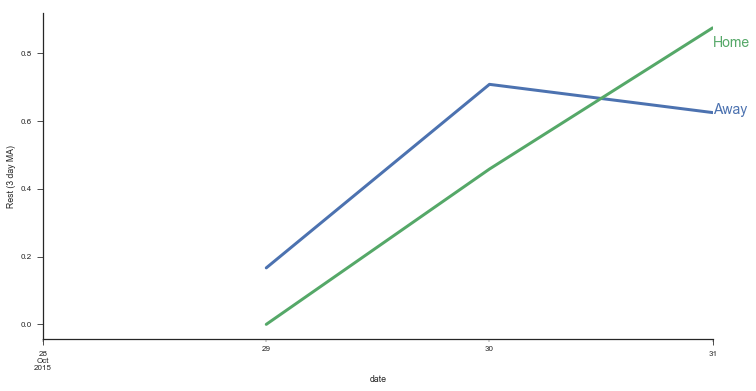

In [210]:
# Use seaborn .color_palette to set up the color status for blue and green and set them as hex strings, b= 0, and g= 1
with sns.color_palette() as pal:
    b, g = pal.as_hex()[:2]
    
# Since in the reference that using .query('away_team < 7') won't get any results, so I change the query as 'away_team < 3'
# Let ax equals the rest data for long to wide format by .unstack(), and show the result of the query('away_team < 3')
# Also provide rolling window calculation with size= 2( in the reference is 7), and calculate the mean by .mean() 
# In the end do the use .plot() to the plot with figsize= (12, 6) giving the width= 12 inches and height= 6 inches for the tuple, and set the linewidth as 3 inches and not place a legend on the axes by legend=False  
ax=(rest.unstack()
        .query('away_team < 3')
        .rolling(2)
        .mean()
        .plot(figsize=(12, 6), linewidth=3, legend=False))

# Set up ylabel='Rest (3 day MA)'
ax.set(ylabel='Rest (3 day MA)')

# Use .annotate() to add the description for the line "Home", and the location in the plot (rest.index[-1][0], 0.82) which means in x axis is rest.index[-1][0] which is the timestamp '2015-10-31 00:00:00'and the y axis is 0.82
# Also the color= green, and the word size= 14
# In the reference here is (rest.index[-1][0], 1.02)
ax.annotate("Home", (rest.index[-1][0], 0.82), color=g, size=14)

# Use .annotate() to add the description for the line "Away", and the location in the plot (rest.index[-1][0], 0.62) which means in x axis is rest.index[-1][0] which is the timestamp '2015-10-31 00:00:00'and the y axis is 0.62
# Also the color= blue, and the word size= 14
# In the reference is (rest.index[-1][0], 0.82)
ax.annotate("Away", (rest.index[-1][0], 0.62), color=b, size=14)

# Use .despine function to remove the top and right spines from plot
sns.despine()

# Reference
1. http://tomaugspurger.github.io/modern-5-tidy.html
2. https://pandas.pydata.org/pandas-docs/stable/index.html